## Libraries

In [27]:
from typing import Dict, Union
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from preprocessing import StatisticalPreprocessing, FromModelPreprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator
from sklearn.exceptions import ConvergenceWarning
from tqdm.notebook import tqdm
from warnings import filterwarnings
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.utils import resample
import numpy as np

filterwarnings(action="ignore", category=ConvergenceWarning)
sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
transformers: Dict[str, Union[FromModelPreprocessing, StatisticalPreprocessing]] = {
    "from_model": FromModelPreprocessing(),
    "statistical": StatisticalPreprocessing(),
}

In [3]:
def transformation_configuration(model: BaseEstimator, train_set: pd.DataFrame, val_set: pd.DataFrame, max_features: int = 100):
    results = {tr: [] for tr in transformers.keys()}

    for name, transformer in tqdm(transformers.items(), desc="Evaluating number of features..."):
        pbar = tqdm(range(max_features), total=max_features)
        if name == "statistical":
            transformer.fit_transform(train_set, "nbest")
        else:
            transformer.fit_transform(train_set, model)

        for i in pbar:
            pbar.set_description("Fit training...")
            train_data = transformer.change_fitted_data(i+1)
            X_train, y_train = train_data.drop(columns=["ACTIVE"]), train_data["ACTIVE"]

            pbar.set_description("Transform val...")
            X_val, y_val = val_set.drop(columns=["ACTIVE"]), val_set["ACTIVE"]
            X_val = transformer.transform(X_val)

            pbar.set_description("Fitting and predicting...")
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_val)[:, 1]

            results[name].append(roc_auc_score(y_val, y_pred))
            pbar.set_description("Score added!")
    return results

## Data

In [4]:
full_train_set = pd.read_csv("./all_features.csv").set_index("INDEX")
train_set: pd.DataFrame
test_set: pd.DataFrame
train_set, test_set = train_test_split(full_train_set, test_size=0.3, random_state=20241209)

In [5]:
actual_train_set: pd.DataFrame
val_set: pd.DataFrame
actual_train_set, val_set = train_test_split(train_set, test_size=0.3, random_state=20241208)

## Models

### Logistic regression

In [10]:
model = LogisticRegression(class_weight="balanced")

In [ ]:
results = transformation_configuration(model, actual_train_set, val_set, 127)

pd.DataFrame(results).to_csv("./logreg_best_feature_num.csv")

Evaluating number of features...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

KeyboardInterrupt: 

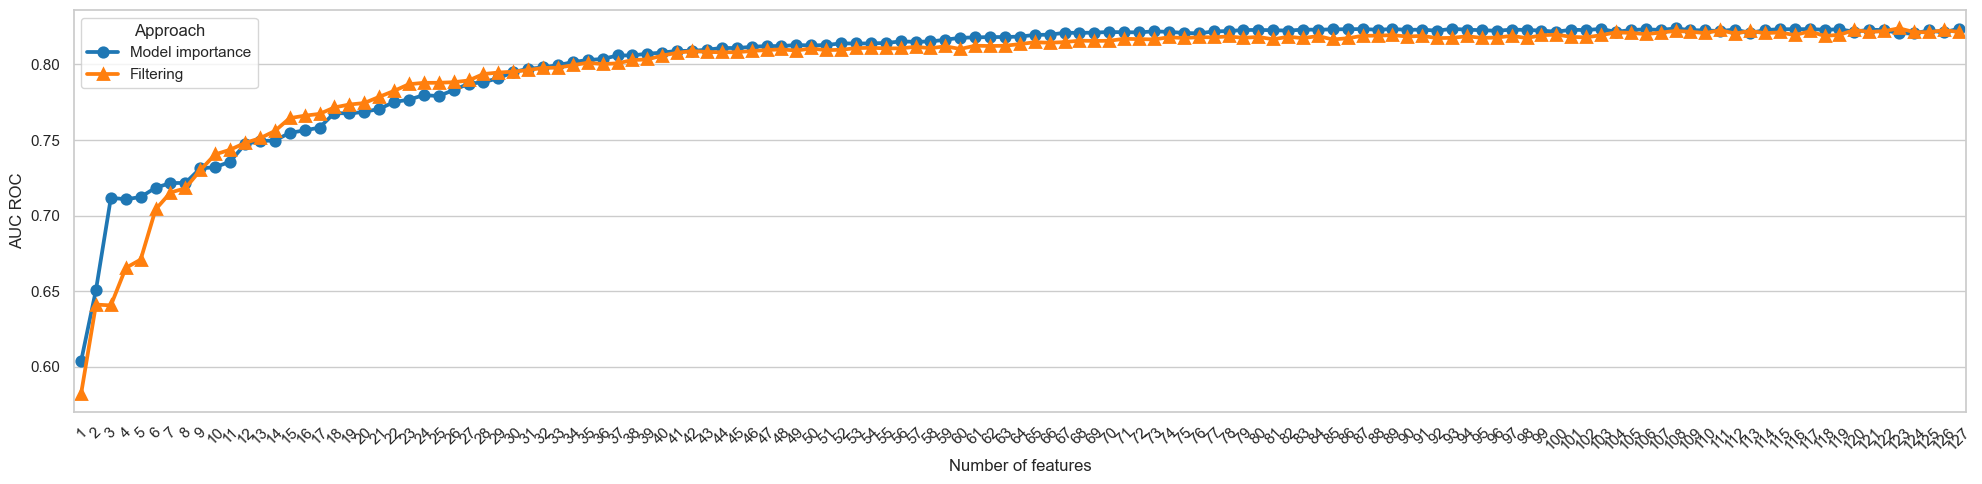

In [ ]:
data = pd.read_csv("./logreg_best_feature_num.csv", index_col=0)
def plot_feature_auc(data: pd.DataFrame):
    data["Number of features"] = data.index + 1
    data.columns = ["Model importance", "Filtering", "Number of features"]
    data = data.melt("Number of features")
    data.columns = ["Number of features", "Approach", "ROC AUC"]


    plt.figure(figsize=(20, 5))
    sns.pointplot(data, x="Number of features", y="ROC AUC", hue="Approach", markers=["o", "^"])
    plt.xlabel("Number of features")
    plt.ylabel("AUC ROC")
    plt.tick_params("x", labelrotation=45)
    plt.tight_layout()
    plt.show()

plot_feature_auc(data)

In [ ]:
transform = FromModelPreprocessing()

train_data = transform.fit_transform(train_set, model, 70)
X_train, y_train = train_data.drop(columns=["ACTIVE"]), train_data["ACTIVE"]

X_test, y_test = transform.transform(test_set.drop(columns=["ACTIVE"])), test_set["ACTIVE"]

In [ ]:
X_train.columns

Index(['n_amides', 'log_p', 'n_secamines', 'n_acceptors', 'n_carboxacids',
       'n_ethers', 'n_alihydroxyls', 'exact_weight', 'n_priamines',
       'n_alkenes', 'n_phenols', 'z_ecfp_3', 'n_bonds', 'n_oxos',
       'n_heavyatoms', 'z_ecfp_61', 'z_ecfp_41', 'n_arohydroxyls', 'n_donors',
       'z_ecfp_1', 'n_sulfoanamids', 'n_teramines', 'z_ecfp_60', 'z_ecfp_77',
       'z_ecfp_18', 'z_ecfp_31', 'n_rotbonds', 'z_ecfp_68', 'z_ecfp_85',
       'z_ecfp_46', 'z_ecfp_25', 'n_arorings', 'z_ecfp_29', 'z_ecfp_66',
       'z_ecfp_58', 'z_ecfp_73', 'z_ecfp_5', 'z_ecfp_74', 'z_ecfp_94',
       'z_ecfp_55', 'z_ecfp_71', 'z_ecfp_78', 'z_ecfp_83', 'z_ecfp_56',
       'z_ecfp_13', 'z_ecfp_0', 'z_ecfp_26', 'z_ecfp_2', 'z_ecfp_62',
       'z_ecfp_59', 'z_ecfp_24', 'z_ecfp_27', 'z_ecfp_4', 'z_ecfp_8',
       'z_ecfp_75', 'z_ecfp_95', 'z_ecfp_22', 'z_ecfp_47', 'z_ecfp_7',
       'z_ecfp_37', 'z_ecfp_19', 'z_ecfp_57', 'z_ecfp_67', 'n_halogens',
       'z_ecfp_20', 'z_ecfp_35'],
      dtype='object')

In [32]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

n_iterations = 1000
auc_scores = []

for i in tqdm(range(n_iterations)):
    # Resample the test set with replacement
    indices = resample(range(len(y_test)), replace=True)
    y_test_resampled = y_test.iloc[indices]
    y_pred_resampled = y_pred[indices]
    
    # Compute AUC for the resampled set
    auc_scores.append(roc_auc_score(y_test_resampled, y_pred_resampled))

# Calculate statistics
mean_auc = np.mean(auc_scores)
confidence_interval = st.t.interval(0.95, len(auc_scores)-1, loc=mean_auc, scale=st.sem(auc_scores))

print(f"Mean AUC: {mean_auc}")
print(f"95% Confidence Interval: {confidence_interval}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean AUC: 0.8195997910285377
95% Confidence Interval: (0.8193174917710716, 0.8198820902860039)


### Random forests

In [35]:
model = RandomForestClassifier(criterion="entropy", n_jobs=-1, class_weight="balanced", oob_score=roc_auc_score)

In [ ]:
results = transformation_configuration(model, actual_train_set, val_set, 127)

pd.DataFrame(results).to_csv("./randfor_best_feature_num.csv")

Evaluating number of features...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]